In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bz2 # To open zipped files
import re # regular expressions
import os
import gc       #for data extraction
import random
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()
nltk.download("stopwords") 
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
import itertools
import codecs
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string
from collections import Counter
from torchtext.vocab import Vocab
import seaborn as sns
from nltk import pos_tag
from gensim.utils import simple_preprocess
nltk.download('cess_esp')  
nltk.download('words')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils.np_utils import to_categorical

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Unzipping corpora/cess_esp.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
for dirname, _, filenames in os.walk('drive\MyDrive\dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
print(os.listdir('/content/drive/MyDrive/dataset'))


['test.ft.txt', 'test.ft.txt.bz2', 'train.ft.txt.bz2', 'train.ft.txt', 'archive.zip', 'Cod_dataset_importat.ipynb', 'in_spyder_copy.py', 'in_spider_torch.py', 'train.txt', 'ccb0553edb6abafd20c3dec34ee8099d-master.zip', 'dataframe_dataset.py', 'json.py', '.ipynb_checkpoints', 'graphs', 'ccb0553edb6abafd20c3dec34ee8099d-master', 'in_spyder.py', 'review.h5']


In [ ]:
train_file = bz2.BZ2File('/content/drive/MyDrive/dataset/train.ft.txt.bz2')
test_file = bz2.BZ2File('/content/drive/MyDrive/dataset/test.ft.txt.bz2')

In [ ]:
train_file_lines = train_file.readlines()
#train_file_lines=random.sample(train_file_lines, 1000000)
test_file_lines = test_file.readlines()
#test_file_lines=random.sample(test_file_lines, 100000)
train_file_lines=train_file_lines[:100000]
test_file_lines = test_file_lines[:100000]
num_train = 10000
num_test = 10000


In [ ]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [ ]:
def remove_underscores(sentence):
    sentence= sentence.replace("_"," ")
    return sentence

In [ ]:
spanish_words =  set(nltk.corpus.cess_esp.words())
english_words = set(nltk.corpus.words.words())
stopwords_english = stopwords.words('english')
stopwords_spanish = stopwords.words('spanish')
stopwords = stopwords_english + stopwords_spanish

def remove_stop_words(sentence):     #remove stop words and meaningless words
    new_sentence=""
    for word in sentence.split():
        word=word.lower()
        if word in english_words or word in spanish_words and word not in stopwords and word.isalpha():
            new_sentence=new_sentence+" "+word
        word_tokenize(new_sentence)
    return new_sentence

In [ ]:
def lemmatize(sentence, min_word_length):        #to lemmatize words and loose the ones with length less than equal to 3.
    sent = ""
    for word in sentence.split():
        if len(lemmatizer.lemmatize(word))>=min_word_length:
            sent= sent+" "+lemmatizer.lemmatize(word)
    return(sent)

In [ ]:
def split_label_review(dataa):
    #takes in list of raw data and returns list of string sentences and the list of their corresponding labels.
    labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in dataa]
  
    
    
    reviews = [re.split("__label__[1|2]",str(lines))[1].strip().lower() for lines in dataa]
    return(reviews,labels)

In [ ]:
def preprocessed_data(raw_text):        #takes in list of raw data and returns list of processed string sentences and the list of their corresponding labels.
    reviews = [lemmatize_and_filter(remove_stop_words(BeautifulSoup(re.sub(r'[^\w\s]|^https?:\/\/.*[\r\n]*|\d+', '', remove_underscores(str(lines)).strip().lower()), "lxml").text),3) for lines in raw_text]  
        
    return(reviews)

In [ ]:
def convert_labels(labels):
    refined_labels = [1 if x == '2' else 0 for x in labels]
    refined_labels = [0 if x == '1' else 1 for x in labels]

    return refined_labels

   

In [ ]:
def split_train_into_train_validate(data_,validation_ratio):    #Takes in list of (raw or processed string) data and splits in train validation and returns in same format
    
    data=data_
    
    train_size = int(len(data)*(1-validation_ratio))
    
    random.shuffle(data)

    validate_samples= data[train_size:]

    data = data[:train_size]
    
    return(data,validate_samples)


In [ ]:
def split_into_negative_positive(dataa):
    negative_reviews=[]      # list of all negative reviews
    positive_reviews=[]      # list of all positive reviews

    for lines in dataa:
        lines= str(lines).lower()
        x=re.findall("1|2", lines)[0]
        if x=="1":
            negative_reviews.append(lines)
        elif x=="2":
            positive_reviews.append(lines)
    return(negative_reviews, positive_reviews)

In [ ]:
train_file_lines,validation_file_lines = split_train_into_train_validate(train_file_lines, 0.25)
negative_reviews, positive_reviews = split_into_negative_positive(train_file_lines)
negative_reviews,negative_labels = split_label_review(negative_reviews)
positive_reviews,positive_labels = split_label_review(positive_reviews)
negative_reviews = preprocessed_data(negative_reviews)
positive_reviews=preprocessed_data(positive_reviews)
#training_sentences, training_labels = split_label_review(train_file_lines)
final_labels = np.concatenate([positive_labels, negative_labels], 0)
final_reviews = positive_reviews + negative_reviews

In [ ]:
final_labels.shape

(75000,)

In [ ]:

negative_reviews_val, positive_reviews_val = split_into_negative_positive(validation_file_lines)
negative_reviews_val,negative_labels_val = split_label_review(negative_reviews_val)
positive_reviews_val,positive_labels_val = split_label_review(positive_reviews_val)
negative_reviews_val = preprocessed_data(negative_reviews_val)
positive_reviews_val =preprocessed_data(positive_reviews_val)
#training_sentences, training_labels = split_label_review(train_file_lines)
final_labels_val = np.concatenate([positive_labels_val, negative_labels_val], 0)
final_reviews_val = positive_reviews_val + negative_reviews_val

In [ ]:
print(final_labels[0])
print(final_reviews[0])
print(final_labels_val[0])
print(final_reviews_val[0])

1
 have dry the point that sometimes need wear two dark and prescription from minute minute that stopped after starting with optometrist still need wear dark glass one pair outside often but the vision settled down and never bad that have stay indoors the dark phew
1
 top before bought this camera worried about some the guess you cant please everyone long you can recharge the camera carry spare battery you will fine the zoom great but the really outstanding feature this camera the wide angle lens you wont just for those indoor family great outdoors too taking additional scenery without distortion the panorama feature easy use too took day and love this camera


In [ ]:
def build_sentence_final_label(raw_data):
    
    refined_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in raw_data]
    refined_labels = [1 if x.split(' ')[0] == '__label__2' else 0 for x in raw_data]
    refined_sentences = [x.split(' ', 1)[1][:-1].lower() for x in raw_data]
    
    labels_list = np.squeeze(refined_labels).tolist()
    freqs = []
    for sentence,labels in zip(refined_sentences,labels_list):
        
            pair = (sentence,labels)
            freqs += pair
    return freqs

print(build_sentence_final_label(train_file_lines[0:5]))

["it helps: i have dry eyes to the point that sometimes i need to wear two pairs of dark lenses, and my prescription fluctuates from minute to minute. that stopped after starting with theratears (optometrist suggested). i still need to wear dark glass (one pair) outside often, but the vision has settled down and it's never so bad that i have to stay indoors in the dark. phew.", 1, "a classic work, still the best: if you want to understand plato, i can heartily recommend a two-step process.first, read up on him in copleston'sa history of philosophy, vol. 1: greece and rome from the pre-socratics to plotinus. you would probably want to read about the pre-socratics and the sophists as well.then, get yourself a copy of this book, and go through it, dialogue by dialogue. i don't think you can go far wrong, and you will have a firm understanding of one of the greatest philosophers who ever lived --- well, two, if you count socrates!", 1, "ok: this costume is very flimsy, but the bright pink 

In [ ]:
negative_reviews_test,positive_reviews_test = split_into_negative_positive(test_file_lines)
negative_reviews_test,negative_labels_test = split_label_review(negative_reviews_test)
positive_reviews_test,positive_labels_test = split_label_review(positive_reviews_test)
negative_reviews_test = preprocessed_data(negative_reviews_test)
positive_reviews_test =preprocessed_data(positive_reviews_test)
final_labels_test = np.concatenate([positive_labels_test, negative_labels_test], 0)
final_reviews_test = positive_reviews_test + negative_reviews_test

In [ ]:
print(final_labels_test[0])
print(final_reviews_test[0])

1
 great lovely pat one the great her generation have this for and still love when good mood feel better bad mood just like sugar the rain this just life are and just kill one hidden this desert isle book why she never made big just beyond play this matter black white young old male female everybody one thing who that singing


In [ ]:
def build_freqs(refined_reviews, refined_labels):
    labels_list = np.squeeze(refined_labels).tolist()
    freqs = {}
    for sentence,labels in zip(refined_reviews,labels_list):
        for word in sentence.split():
            pair = (word,labels)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs


freqs = build_freqs(final_reviews, final_labels)
print(freqs)

{('have', 1): 17978, ('dry', 1): 311, ('the', 1): 149823, ('point', 1): 847, ('that', 1): 28793, ('sometimes', 1): 643, ('need', 1): 2431, ('wear', 1): 312, ('two', 1): 2625, ('dark', 1): 564, ('and', 1): 87874, ('prescription', 1): 8, ('from', 1): 9404, ('minute', 1): 222, ('stopped', 1): 119, ('after', 1): 3553, ('starting', 1): 253, ('with', 1): 21879, ('optometrist', 1): 1, ('still', 1): 3886, ('glass', 1): 182, ('one', 1): 14916, ('pair', 1): 245, ('outside', 1): 225, ('often', 1): 639, ('but', 1): 19492, ('vision', 1): 122, ('settled', 1): 24, ('down', 1): 2209, ('never', 1): 2891, ('bad', 1): 1427, ('stay', 1): 507, ('indoors', 1): 12, ('phew', 1): 1, ('classic', 1): 2562, ('work', 1): 5070, ('best', 1): 7350, ('you', 1): 24759, ('want', 1): 2708, ('understand', 1): 1148, ('plato', 1): 11, ('can', 1): 7278, ('heartily', 1): 20, ('recommend', 1): 3371, ('read', 1): 10590, ('him', 1): 2062, ('history', 1): 1278, ('philosophy', 1): 122, ('vol', 1): 36, ('would', 1): 6843, ('probabl

In [ ]:
words = Counter() #Dictionary that will map a word to the number of times it appeared in all the training sentences
for  sentence in final_reviews:
    #The sentences will be stored as a list of words/tokens
    
    for word in sentence.split():
        words.update([word.lower()]) #Converting all the words to lower case
for  sentence in final_reviews_test:
    #The sentences will be stored as a list of words/tokens
    
    for word in sentence.split():
        words.update([word.lower()]) #Converting all the words to lower case
        
    
        


print(words)

# Sorting the words according to the number of appearances, with the most common word being first
notok_words = sorted(words, key=words.get, reverse=True)
# Adding padding and unknown to our vocabulary so that they will be assigned an index
words = ['_PAD','_UNK'] + notok_words
# Dictionaries to store the word to index mappings and vice versa
#word2idx = {o:i for i,o in enumerate(words)}
#idx2word = {i:o for i,o in enumerate(words)}


Counter({'the': 706805, 'and': 376743, 'this': 262978, 'for': 144988, 'that': 139018, 'not': 108529, 'you': 108376, 'but': 100843, 'book': 99960, 'with': 99023, 'have': 88472, 'are': 75989, 'one': 67458, 'all': 56283, 'like': 51941, 'great': 51870, 'good': 51062, 'very': 49608, 'movie': 47427, 'they': 46984, 'just': 46151, 'from': 45512, 'about': 41499, 'time': 41387, 'would': 39626, 'read': 39389, 'out': 39024, 'what': 37119, 'more': 35947, 'there': 34643, 'will': 34335, 'had': 33981, 'when': 33314, 'his': 32807, 'get': 32275, 'only': 30929, 'dont': 30535, 'can': 30049, 'your': 29304, 'really': 28745, 'some': 28735, 'who': 27156, 'than': 25799, 'first': 25474, 'much': 24877, 'even': 24821, 'work': 24693, 'her': 24508, 'well': 24459, 'love': 24205, 'other': 24074, 'them': 23587, 'because': 22707, 'were': 22573, 'best': 22273, 'after': 21582, 'these': 21346, 'too': 21087, 'story': 21058, 'been': 20985, 'how': 20862, 'album': 20614, 'better': 20214, 'buy': 20046, 'which': 19879, 'their':

In [ ]:
final_data = []

# loop through our selected words
for word in words:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    # append the word counts to the table
    final_data.append([word, pos, neg])
    
print(final_data)



[['_PAD', 0, 0], ['_UNK', 0, 0], ['the', 149823, 156633], ['and', 87874, 74486], ['this', 55005, 58575], ['for', 31871, 29587], ['that', 28793, 31682], ['not', 14966, 31035], ['you', 24759, 21293], ['but', 19492, 24172], ['book', 23258, 22010], ['with', 21879, 20582], ['have', 17978, 19801], ['are', 16493, 15970], ['one', 14916, 14461], ['all', 12494, 11820], ['like', 10543, 11794], ['great', 17161, 5255], ['good', 12866, 9371], ['very', 11320, 10030], ['movie', 10744, 11937], ['they', 8699, 11124], ['just', 8487, 11485], ['from', 9404, 9947], ['about', 8686, 9610], ['time', 8993, 9100], ['would', 6843, 10200], ['read', 10590, 7781], ['out', 7718, 9078], ['what', 7218, 8902], ['more', 8012, 7490], ['there', 6531, 8599], ['will', 7805, 6727], ['had', 6056, 8555], ['when', 7043, 7322], ['his', 8393, 5884], ['get', 6127, 7712], ['only', 5427, 7715], ['dont', 4371, 8690], ['can', 7278, 5814], ['your', 5495, 6575], ['really', 6294, 5978], ['some', 6301, 6140], ['who', 6537, 5188], ['than', 

In [ ]:
# select some words to appear in the report. we will assume that each word is unique (i.e. no duplicates)
keys = ['sad','happy','horrible','great','beautiful','hate','love']

# list representing our table of word counts.
# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
data = []

# loop through our selected words
for word in keys:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    # append the word counts to the table
    data.append([word, pos, neg])
    
data

[['sad', 444, 577],
 ['happy', 1253, 632],
 ['horrible', 106, 1636],
 ['great', 17161, 5255],
 ['beautiful', 1548, 418],
 ['hate', 289, 703],
 ['love', 7893, 2634]]

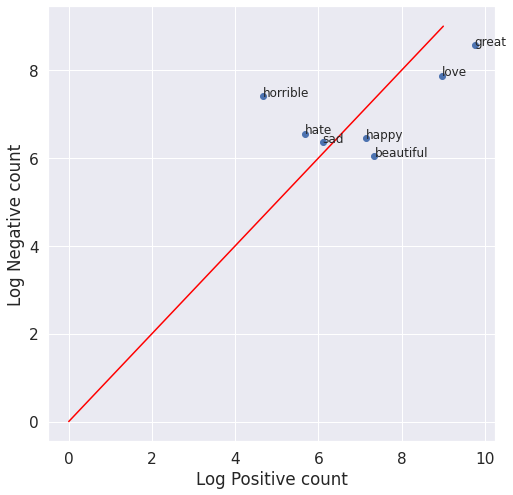

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

In [ ]:
final_data_reduced = []

# loop through our selected words
for word in words[:15]:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    # append the word counts to the table
    final_data.append([word, pos, neg])
    
print(final_data_reduced)

[]


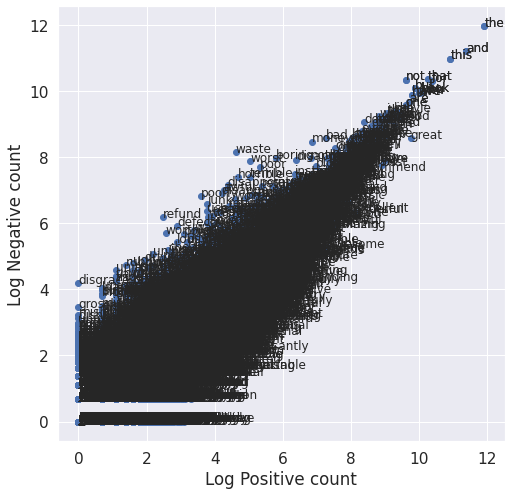

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1  for x in final_data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in final_data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(final_data)):
    ax.annotate(final_data[i][0], (x[i], y[i]), fontsize=12)



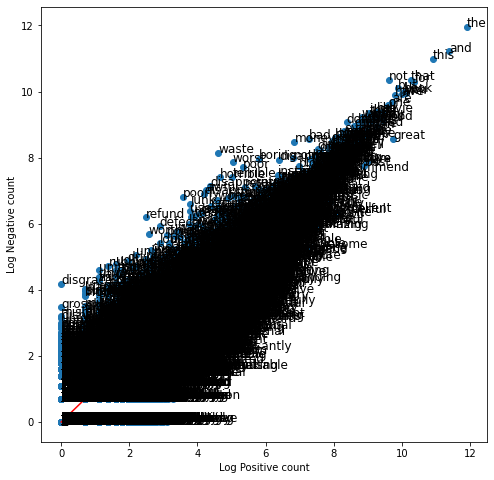

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1  for x in final_data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in final_data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(final_data)):
    ax.annotate(final_data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()
plt.close()

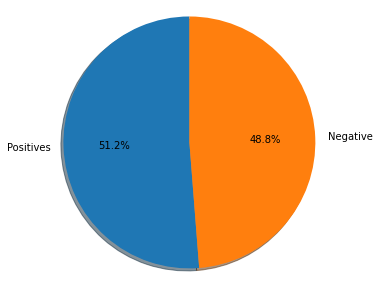

In [ ]:
fig = plt.figure(figsize=(5, 5))

# labels for the two classes
labels = 'Positives', 'Negative'

# Sizes for each slide
sizes = [len(positive_reviews), len(negative_reviews)] 

# Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Display the chart
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


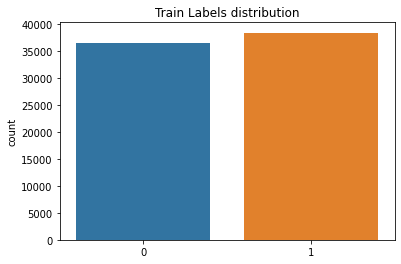

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_1 = sns.countplot(final_labels)
plt.title('Train Labels distribution')
plt.show(plot_1)
plt.close()
plt.clf()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


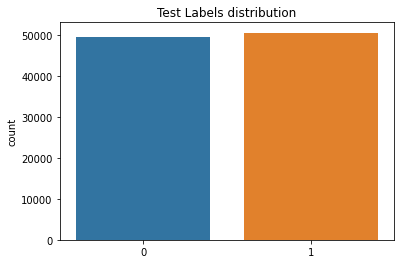

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_2 = sns.countplot(final_labels_test)
plt.title('Test Labels distribution')
plt.show(plot_2)
plt.close()
plt.clf()

In [ ]:
#final_reviews_size =  len(training_padded)

#plt.xlabel("#words in reviews")
#plt.ylabel("Frequency")
#plt.title("Word Frequency Distribution in Reviews")
#plt.bar(words,len(words), color='g')
#plt.show()
#plt.close()
#plt.clf()

In [ ]:

#final_reviews_size =  len(test_file_lines)
##train_sentences_size =  len( final_reviews)
#train_label_len = pd.DataFrame({"labels": final_labels, "len": train_sentences_size})
#print(train_label_len.head())


#neg_mean_len = train_label_len.groupby('labels')['len'].mean().values[0]
#pos_mean_len = train_label_len.groupby('labels')['len'].mean().values[1]

#print(f"Negative mean length: {neg_mean_len:.2f}")
#print(f"Positive mean length: {pos_mean_len:.2f}")
#print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
##sns.catplot(x='labels', y='len', data=train_label_len, kind='box')
#plt.xlabel(f"labels (0->negative, 1->positive)")
#plt.ylabel(f"#words in reviews")
#plt.title("Review Size Categorization")


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
training_sentences,training_labels = split_label_review(train_file_lines)
training_sentences = preprocessed_data(training_sentences)
validation_sentences,validation_labels = split_label_review(validation_file_lines)
validation_sentences = preprocessed_data(validation_sentences)
testing_sentences,testing_labels = split_label_review(test_file_lines)
testing_sentences = preprocessed_data(testing_sentences)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Word Frequency Distribution in Reviews')

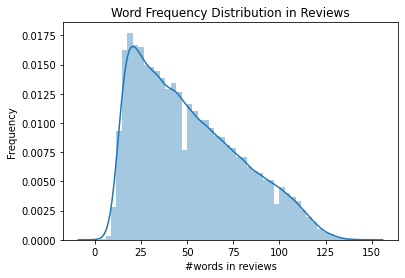

In [ ]:
train_sentences_size = list(map(lambda x: len(x.split()), training_sentences))

sns.distplot(train_sentences_size)
plt.xlabel("#words in reviews")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution in Reviews")

In [ ]:
train_label_len = pd.DataFrame({"labels": training_labels, "len": train_sentences_size})
train_label_len.head()

,labels,len
0,1,45
1,1,59
2,0,41
3,0,100
4,1,95


Negative mean length: 36570.00
Positive mean length: 38430.00
Mean Difference: -1860.00


Text(0.5, 1.0, 'Review Size Categorization')

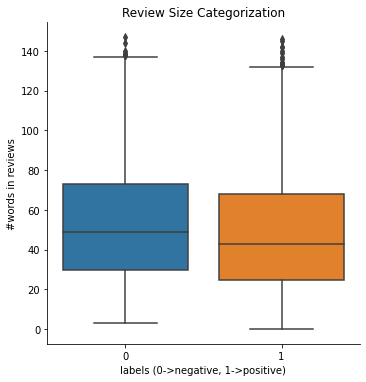

In [ ]:
neg_mean_len = len(negative_labels)
pos_mean_len = len(positive_labels)

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len - pos_mean_len:.2f}")
sns.catplot(x='labels', y='len', data=train_label_len, kind='box')
plt.xlabel("labels (0->negative, 1->positive)")
plt.ylabel("#words in reviews")
plt.title("Review Size Categorization")

In [ ]:

#training_sentences= final_reviews
#training_labels = final_labels




In [ ]:
#validation_sentences = final_reviews_val
#validation_labels = final_labels_val

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>", num_words = len(words))
tokenizer.fit_on_texts(training_sentences)

In [ ]:
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'the': 2, 'and': 3, 'this': 4, 'for': 5, 'that': 6, 'you': 7, 'not': 8, 'book': 9, 'but': 10, 'with': 11, 'have': 12, 'are': 13, 'one': 14, 'all': 15, 'movie': 16, 'great': 17, 'like': 18, 'good': 19, 'very': 20, 'just': 21, 'they': 22, 'from': 23, 'read': 24, 'about': 25, 'time': 26, 'would': 27, 'out': 28, 'what': 29, 'more': 30, 'there': 31, 'had': 32, 'will': 33, 'when': 34, 'his': 35, 'get': 36, 'only': 37, 'can': 38, 'dont': 39, 'some': 40, 'really': 41, 'your': 42, 'who': 43, 'than': 44, 'first': 45, 'much': 46, 'her': 47, 'even': 48, 'well': 49, 'love': 50, 'work': 51, 'other': 52, 'them': 53, 'because': 54, 'were': 55, 'story': 56, 'best': 57, 'film': 58, 'too': 59, 'after': 60, 'these': 61, 'been': 62, 'how': 63, 'better': 64, 'which': 65, 'buy': 66, 'she': 67, 'their': 68, 'any': 69, 'way': 70, 'album': 71, 'could': 72, 'did': 73, 'also': 74, 'think': 75, 'many': 76, 'then': 77, 'most': 78, 'little': 79, 'into': 80, 'new': 81, 'ever': 82, 'see': 83, 'over': 84, 

In [ ]:
#reverse_word_index = dict([(value,key) for key,value in word_index.items()])

In [ ]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding = 'post', truncating = 'post')

#del training_sentences,training_sequences

# Need this block to get it to work with TensorFlow 
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)


In [ ]:
tokenizer.fit_on_texts(validation_sentences)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding = 'post', truncating = 'post')

del validation_sentences,validation_sequences

# Need this block to get it to work with TensorFlow 
import numpy as np
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

In [ ]:
vocab_size = len(words)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 10),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          343140    
_________________________________________________________________
global_average_pooling1d (Gl (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 200)               2200      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                4824      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 350,189
Trainable params: 350,189
Non-trainable params: 0
_________________________________________________________________


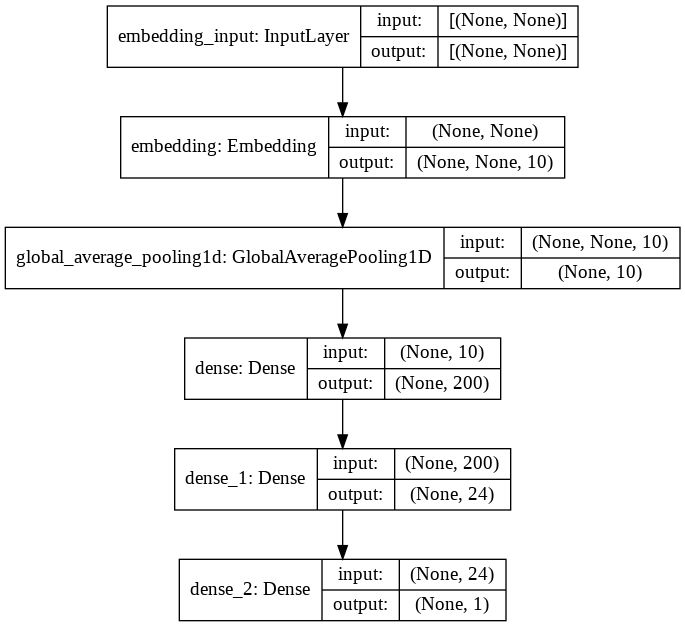

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
#validation_sentences, validation_labels = split_label_review(validation_file_lines)
#validation_sentences=preprocessed_data(validation_sentences)

#validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
#validation_padded = pad_sequences(validation_sequences)

#validation_padded = np.array(validation_padded)
#validation_labels = np.array(validation_labels)

#del validation_sentences,validation_sequences

In [ ]:
history = model.fit(training_padded, training_labels, epochs=100, validation_data=(validation_padded, validation_labels),verbose=1,callbacks = [ tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.25, patience=2, cooldown=0)]
)

Epoch 1/100
2344/2344 [==============================] - 17s 7ms/step - loss: 0.4894 - accuracy: 0.8110 - val_loss: 0.9755 - val_accuracy: 0.6610
Epoch 2/100
2344/2344 [==============================] - 16s 7ms/step - loss: 0.3472 - accuracy: 0.8766 - val_loss: 1.0767 - val_accuracy: 0.6491
Epoch 3/100
2344/2344 [==============================] - 16s 7ms/step - loss: 0.3168 - accuracy: 0.8901 - val_loss: 0.9617 - val_accuracy: 0.6416
Epoch 4/100
2344/2344 [==============================] - 19s 8ms/step - loss: 0.3290 - accuracy: 0.8962 - val_loss: 1.4986 - val_accuracy: 0.6365
Epoch 5/100
2344/2344 [==============================] - 19s 8ms/step - loss: 0.2903 - accuracy: 0.9046 - val_loss: 1.0225 - val_accuracy: 0.6328
Epoch 6/100
2344/2344 [==============================] - 19s 8ms/step - loss: 0.2682 - accuracy: 0.9156 - val_loss: 1.4627 - val_accuracy: 0.6330
Epoch 7/100
2344/2344 [==============================] - 19s 8ms/step - loss: 0.2561 - accuracy: 0.9195 - val_loss: 1.6013 -

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

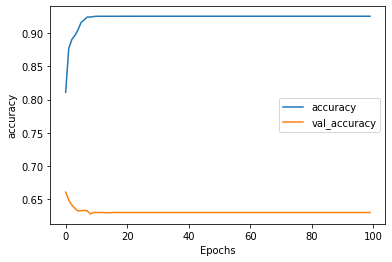

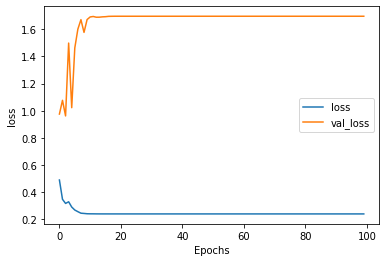

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:




#testing_sentences = final_reviews_test
#testing_labels = final_labels_test
tokenizer.fit_on_texts(testing_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

del testing_sentences,testing_sequences

In [ ]:
model_testing = model.evaluate(testing_padded,testing_labels)

3125/3125 [==============================] - 6s 2ms/step - loss: 2.4103 - accuracy: 0.5263


In [ ]:
prediction= model.predict(testing_padded)

In [ ]:
print(prediction[0:15])

[[0.08261149]
 [0.09341434]
 [0.6544257 ]
 [0.45270747]
 [1.339662  ]
 [1.4278936 ]
 [0.5738486 ]
 [0.06583629]
 [0.02505764]
 [0.08668563]
 [0.05523875]
 [0.05769831]
 [0.62881655]
 [0.9298535 ]
 [0.08199966]]


In [ ]:
testing_labels[0:15]

array([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [ ]:
n_train_samples = training_padded.shape[0]
n_val_samples = validation_padded.shape[0]
n_test_samples = testing_padded.shape[0]


In [ ]:
print('We have %d TRAINING samples' % n_train_samples)
print('We have %d VALIDATION samples' % n_val_samples)
print('We have %d TEST samples' % n_test_samples)

We have 75000 TRAINING samples
We have 25000 VALIDATION samples
We have 100000 TEST samples


In [ ]:

train_file = bz2.BZ2File('/content/drive/MyDrive/dataset/train.ft.txt.bz2')
test_file = bz2.BZ2File('/content/drive/MyDrive/dataset/test.ft.txt.bz2')
train_file_lines = train_file.readlines()
#train_file_lines=random.sample(train_file_lines, 100000)
test_file_lines = test_file.readlines()
#test_file_lines=random.sample(test_file_lines, 100000)
##num_train = 10000
#num_test = 10000

train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

train_file_lines,validation_file_lines = split_train_into_train_validate(train_file_lines, 0.25)




In [ ]:

def getDocumentSentimentList(docs,splitStr='__label__'):
    docSentimentList=[]
    for i in range(len(docs)):
        #print('Processing doc ',i,' of ',len(docs))
        text=str(docs[i])
        #print(text)
        splitText=text.split(splitStr)
        secHalf=splitText[1]
        text=secHalf[2:len(secHalf)-1]
        sentiment=secHalf[0]
        #print('First half:',secHalf[0],'\nsecond half:',secHalf[2:len(secHalf)-1])
        docSentimentList.append([text,sentiment])
    print('Done!!')
    return docSentimentList

In [ ]:
from sklearn.preprocessing import LabelBinarizer


docSentimentList=getDocumentSentimentList(train_file_lines[:100000],splitStr='__label__')
train_df = pd.DataFrame(docSentimentList,columns=['Text','Sentiment'])
train_df['Sentiment'][train_df['Sentiment']=='1'] = 0
train_df['Sentiment'][train_df['Sentiment']=='2'] = 1
#train_df['Sentiment'] = [1 if x == '2' else 0 for x in train_df['Sentiment']]
#train_df['Sentiment'] = [0 if x == '1' else 1 for x in train_df['Sentiment']]
print(train_df.head())


train_df['Sentiment'].value_counts()

train_df['Text'] = preprocessed_data(train_df['Text'])

print(train_df.head())

X_train=train_df['Text']
#X_train = preprocessed_data(X_train)
Y_train = train_df['Sentiment']
#Y_train=np.asarray(train_df['Sentiment'])#.tolist())
Y_train=Y_train.astype('int32')
#lb=LabelBinarizer(pos_label=1,neg_label=0)
#Y_train=lb.fit_transform(Y_train)


#Y_train=to_categorical(num_classes=2,y=Y_train)
#Y_train.shape







Done!!
                                                Text Sentiment
0  Tubular: this is one great super hero movie. i...         1
1  Very disappointed in this video...: As another...         0
2  Don't buy it from this merchant: If you buy th...         0
3  Does not fit in a larger doorway and can't fin...         0
4  leave the lights on before you go to bed: i re...         1
                                                Text Sentiment
0   tubular this one great super hero movie reall...         1
1   very disappointed this video another reviewer...         0
2   dont buy from this merchant you buy this item...         0
3   doe not fit doorway and cant find extension t...         0
4   leave the before you bed remember this pictur...         1


In [ ]:
train_df['Sentiment'].value_counts()

1    50015
0    49985
Name: Sentiment, dtype: int64

In [ ]:
docSentimentList=getDocumentSentimentList(validation_file_lines[:100000],splitStr='__label__')
val_df = pd.DataFrame(docSentimentList,columns=['Text','Sentiment'])
val_df['Sentiment'][val_df['Sentiment']=='1'] = 0
val_df['Sentiment'][val_df['Sentiment']=='2'] = 1
#val_df['Sentiment'] = [1 if x == '2' else 0 for x in val_df['Sentiment']]
#val_df['Sentiment'] = [0 if x == '1' else 1 for x in val_df['Sentiment']]
print(val_df.head())

val_df['Text'] = preprocessed_data(val_df['Text'])
print(val_df.head())

val_df['Sentiment'].value_counts()

X_val=val_df['Text']

#Y_val=np.asarray(val_df['Sentiment'])#.tolist())
Y_val = val_df['Sentiment']
Y_val=Y_val.astype('int32')
#lb=LabelBinarizer(pos_label=1,neg_label=0)
#Y_val=lb.fit_transform(Y_val)


#Y_val=to_categorical(num_classes=2,y=Y_val)
#Y_val.shape







Done!!
                                                Text Sentiment
0  OK story but the style could use some work: Th...         0
1  Diaper Bag Must-Have!: This great blanket has ...         1
2  disppointed: Very disppointed. The handle brok...         0
3  Slides all over the floor!: After reading the ...         0
4  No that great: The book is a good attempt, but...         0
                                                Text Sentiment
0   story but the style could use some work this ...         0
1   diaper bag this great blanket been lifesaver ...         1
2   very the handle broke off after the three tim...         0
3   all over the floor after reading the this and...         0
4   that great the book good attempt but lot miss...         0


In [ ]:
docSentimentList=getDocumentSentimentList(test_file_lines[:100000],splitStr='__label__')
test_df = pd.DataFrame(docSentimentList,columns=['Text','Sentiment'])
test_df['Sentiment'][test_df['Sentiment']=='1'] = 0
test_df['Sentiment'][test_df['Sentiment']=='2'] = 1
print(test_df.head())

test_df['Text'] = preprocessed_data(test_df['Text'])

print(test_df.head())
test_df['Sentiment'].value_counts()

X_test=test_df['Text']
#X_test = preprocessed_data(X_test)
Y_test = test_df['Sentiment']
#Y_test=np.asarray(test_df['Sentiment'])#.tolist())

Y_test=Y_test.astype('int32')
#lb=LabelBinarizer(pos_label=1,neg_label=0)
#Y_test=lb.fit_transform(Y_test)


#Y_test=to_categorical(num_classes=2,y=Y_test)
#Y_test.shape


Done!!
                                                Text Sentiment
0  Great CD: My lovely Pat has one of the GREAT v...         1
1  One of the best game music soundtracks - for a...         1
2  Batteries died within a year ...: I bought thi...         0
3  works fine, but Maha Energy is better: Check o...         1
4  Great for the non-audiophile: Reviewed quite a...         1
                                                Text Sentiment
0   great lovely pat one the great her generation...         1
1   one the best game music for game didnt really...         1
2   within year bought this charger and worked fo...         0
3   work fine but maha energy better check out ma...         1
4   great for the quite bit the and hesitant due ...         1


In [ ]:
max_length=100
vocab_size=10000
#embedding_dim=64
oov_tok="<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tok=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
#vocab_size = len(words)

In [ ]:

tok.fit_on_texts(X_train)
print('Toekizing...done')
seqs=np.array(tok.texts_to_sequences(X_train))
print('Sequencing...done')

X_train=pad_sequences(seqs,maxlen=100, padding = 'post', truncating= 'post')
print('Padding sequences...done')


Toekizing...done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Sequencing...done
Padding sequences...done


In [ ]:
print(train_df['Text'][0])
print(X_train[0])

 tubular this one great super hero movie really like stone arm come with and lot great movie have
[   1    4   14   17  701 1062   41   40   19 1481 1176  122    9    3
  115   17   41   12    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
word_index = tok.word_index
print(word_index)

{'<OOV>': 1, 'the': 2, 'and': 3, 'this': 4, 'for': 5, 'that': 6, 'not': 7, 'you': 8, 'with': 9, 'but': 10, 'book': 11, 'have': 12, 'are': 13, 'one': 14, 'all': 15, 'very': 16, 'great': 17, 'good': 18, 'like': 19, 'they': 20, 'from': 21, 'just': 22, 'would': 23, 'about': 24, 'time': 25, 'out': 26, 'what': 27, 'more': 28, 'had': 29, 'will': 30, 'when': 31, 'there': 32, 'get': 33, 'read': 34, 'only': 35, 'your': 36, 'can': 37, 'dont': 38, 'work': 39, 'really': 40, 'movie': 41, 'some': 42, 'his': 43, 'than': 44, 'well': 45, 'them': 46, 'much': 47, 'first': 48, 'other': 49, 'who': 50, 'even': 51, 'these': 52, 'her': 53, 'after': 54, 'because': 55, 'were': 56, 'love': 57, 'buy': 58, 'too': 59, 'product': 60, 'been': 61, 'how': 62, 'best': 63, 'which': 64, 'use': 65, 'their': 66, 'better': 67, 'any': 68, 'she': 69, 'bought': 70, 'also': 71, 'way': 72, 'could': 73, 'did': 74, 'then': 75, 'new': 76, 'story': 77, 'little': 78, 'album': 79, 'doe': 80, 'many': 81, 'now': 82, 'think': 83, 'into': 8

In [ ]:
reverse_word_index = dict([(value,key) for key,value in word_index.items()])

In [ ]:
# Function takes a tokenized sentence and returns the words
def sequence_to_text(sentence):
    # Looking up words in dictionary
    words = [reverse_word_index.get(word) for word in sentence]
    return(words)

In [ ]:
my_texts = list(map(sequence_to_text, X_train))

In [ ]:
print(my_texts[:15])

[['<OOV>', 'this', 'one', 'great', 'super', 'hero', 'movie', 'really', 'like', 'stone', 'arm', 'come', 'with', 'and', 'lot', 'great', 'movie', 'have', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], ['very', 'disappointed', 'this', 'video', 'another', 'reviewer', 'stated', 'had', 'high', 'for', 'this', 'video', 'too', 'high', 'perhaps', 'that', 'nutshell', 'fitness', 'professional', 'not', 'only', 'there', 'breakdown', 'how', 'the', 'were', 'the', 'choreography', 'did', 'not', 'take', 'into', 'account', 'the', 'fact', 'that', 'the', 'vast', 'majorit

In [ ]:
X_train.shape

(100000, 100)

In [ ]:
#X_test.shape

In [ ]:
#tok.fit_on_texts(X_val)
print('Toekizing...done')
seqs=np.array(tok.texts_to_sequences(X_val))
print('Sequencing...done')
X_val=pad_sequences(seqs,maxlen=100, padding = 'post', truncating= 'post')
print('Padding sequences...done')

Toekizing...done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


Sequencing...done
Padding sequences...done


In [ ]:
X_val.shape

(100000, 100)

In [ ]:
#tok.fit_on_texts(X_test)
print('Toekizing...done')
seqs=np.array(tok.texts_to_sequences(X_test))
print('Sequencing...done')
X_test=pad_sequences(seqs,maxlen=100, padding = 'post', truncating= 'post')
#X_test=pad_sequences(seqs,maxlen=100,  padding = 'post', truncating = 'post'
print('Padding sequences...done')

Toekizing...done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


Sequencing...done
Padding sequences...done


In [ ]:
X_test.shape

(100000, 100)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM,GRU
from keras.preprocessing import sequence
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score    
from tensorflow.python.keras import models, layers, optimizers   
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D
from keras.layers.wrappers import Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [ ]:





def build_rnn_model():
    sequences = layers.Input(shape=(100,))
    embedded = layers.Embedding(vocab_size, 64)(sequences)
    x = layers.GRU(128, return_sequences=True)(embedded)
    x = layers.GRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
    
rnn_model = build_rnn_model()








In [ ]:
rnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
gru (GRU)                    (None, 100, 128)          74112     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101   

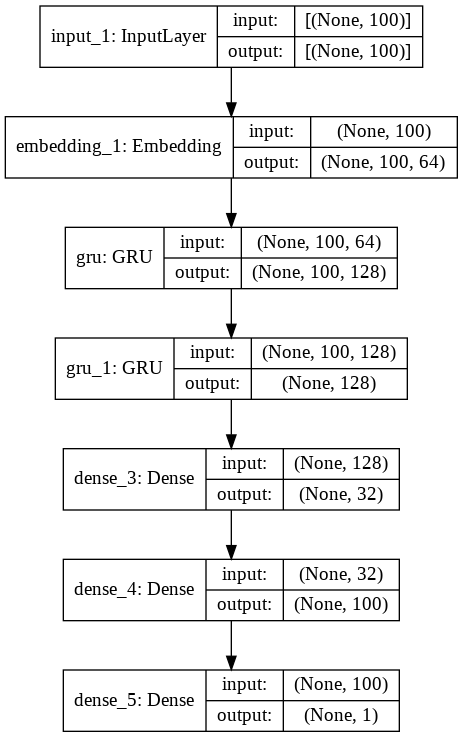

In [ ]:
tf.keras.utils.plot_model(rnn_model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
adam=Adam(lr=0.0001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:

earlyStopping=EarlyStopping(patience=3,monitor='binary_accuracy',min_delta=0.0001,verbose=1)
callbackslist=[earlyStopping]
history = rnn_model.fit(X_train,Y_train,batch_size=128,epochs=2,verbose=1,callbacks=callbackslist, validation_data=(X_val,Y_val))

Epoch 1/2
782/782 [==============================] - 658s 834ms/step - loss: 0.5599 - binary_accuracy: 0.6734 - val_loss: 0.4216 - val_binary_accuracy: 0.8160
Epoch 2/2
782/782 [==============================] - 656s 839ms/step - loss: 0.2935 - binary_accuracy: 0.8788 - val_loss: 0.2795 - val_binary_accuracy: 0.8931


In [ ]:
model_testing = rnn_model.evaluate(X_test,Y_test)

3125/3125 [==============================] - 181s 58ms/step - loss: 0.2942 - binary_accuracy: 0.8893


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:



import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



In [ ]:
import sklearn
plot_roc("RNN Test Baseline", Y_test.argmax(axis=1), (rnn_model.predict(X_test)).argmax(axis=1), color=colors[0], linestyle='--')
plt.legend(loc='lower right')

ValueError: ignored

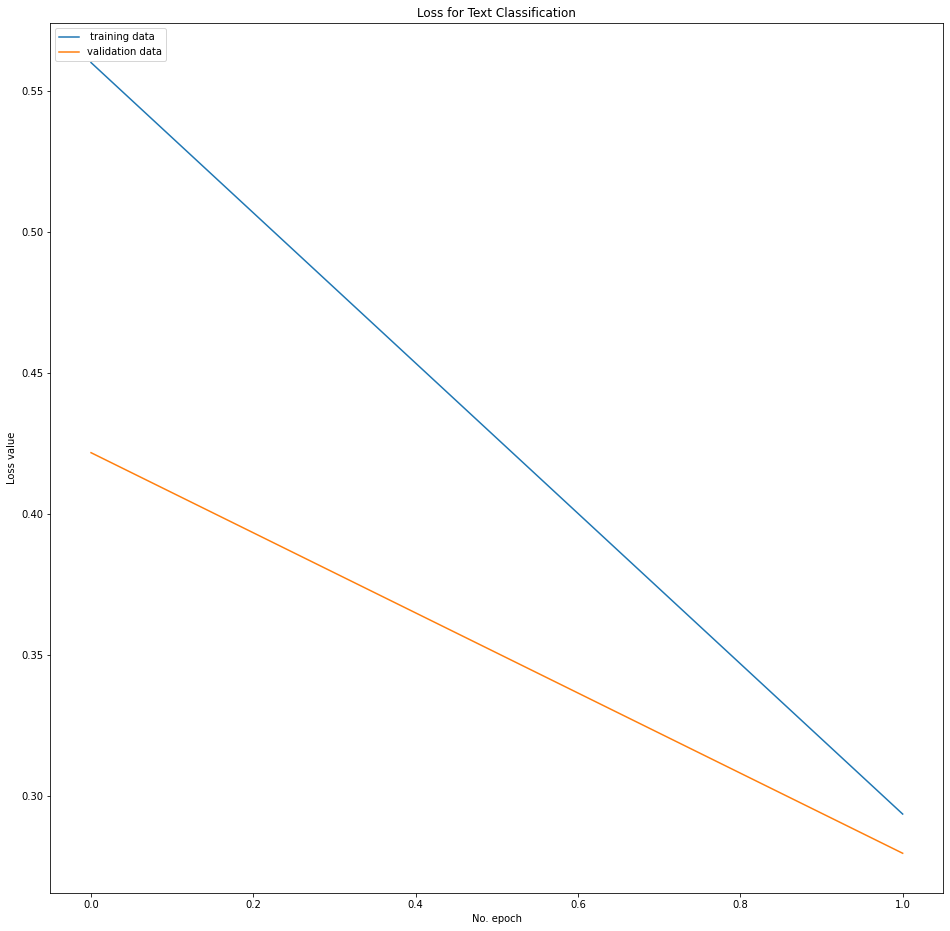

In [ ]:


plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()



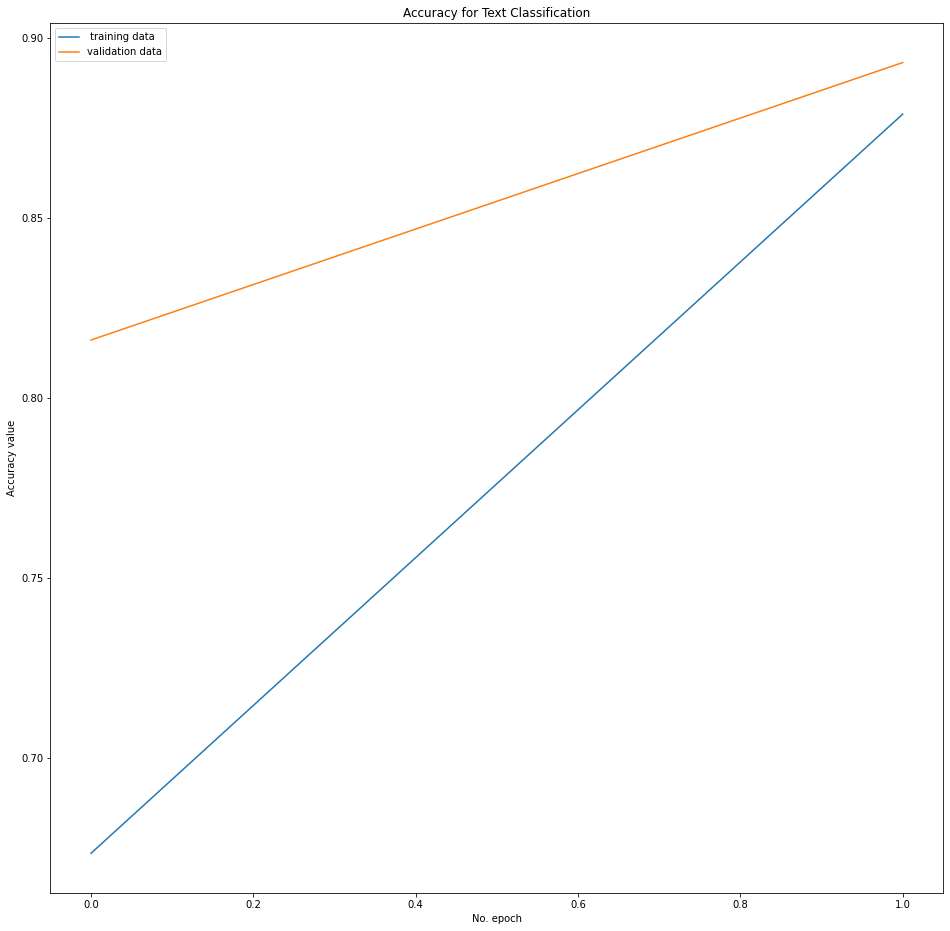

In [ ]:


plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()



In [ ]:


def build_cnn_model():
    sequences = layers.Input(shape=(100,))
    embedded = layers.Embedding(vocab_size, 64)(sequences)
    x = layers.Conv1D(64, 3, activation='relu')(embedded)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(3)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
    
cnn_model = build_cnn_model()



In [ ]:
cnn_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 64)            12352     
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 64)            256 

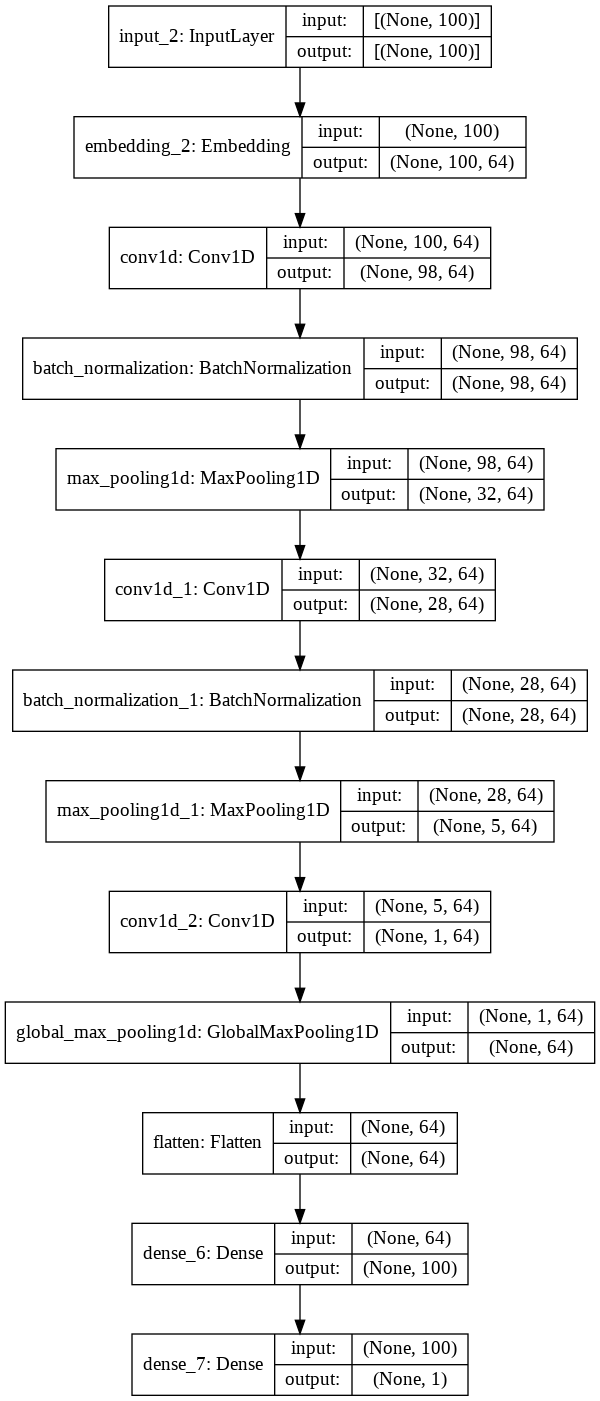

In [ ]:
tf.keras.utils.plot_model(cnn_model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:


earlyStopping=EarlyStopping(patience=3,monitor='binary_accuracy',min_delta=0.0001,verbose=1)
callbackslist=[earlyStopping]
history = cnn_model.fit(
    X_train, 
    Y_train, 
    batch_size=128,
    epochs=2,verbose=1,callbacks=callbackslist, validation_data=(X_val, Y_val)
     )



Epoch 1/2
782/782 [==============================] - 68s 83ms/step - loss: 0.3307 - binary_accuracy: 0.8493 - val_loss: 0.2554 - val_binary_accuracy: 0.8997
Epoch 2/2
782/782 [==============================] - 64s 82ms/step - loss: 0.2042 - binary_accuracy: 0.9193 - val_loss: 0.3240 - val_binary_accuracy: 0.8745


In [ ]:
cnn_model.evaluate(X_test,Y_test)

3125/3125 [==============================] - 19s 6ms/step - loss: 0.3435 - binary_accuracy: 0.8696


[0.3435257375240326, 0.8695799708366394]

In [ ]:
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
plot_roc("CNN Test Baseline", Y_test.argmax(axis=1), (cnn_model.predict(X_test)).argmax(axis=1), color=colors[0], linestyle='--')
plt.legend(loc='lower right')

ValueError: ignored

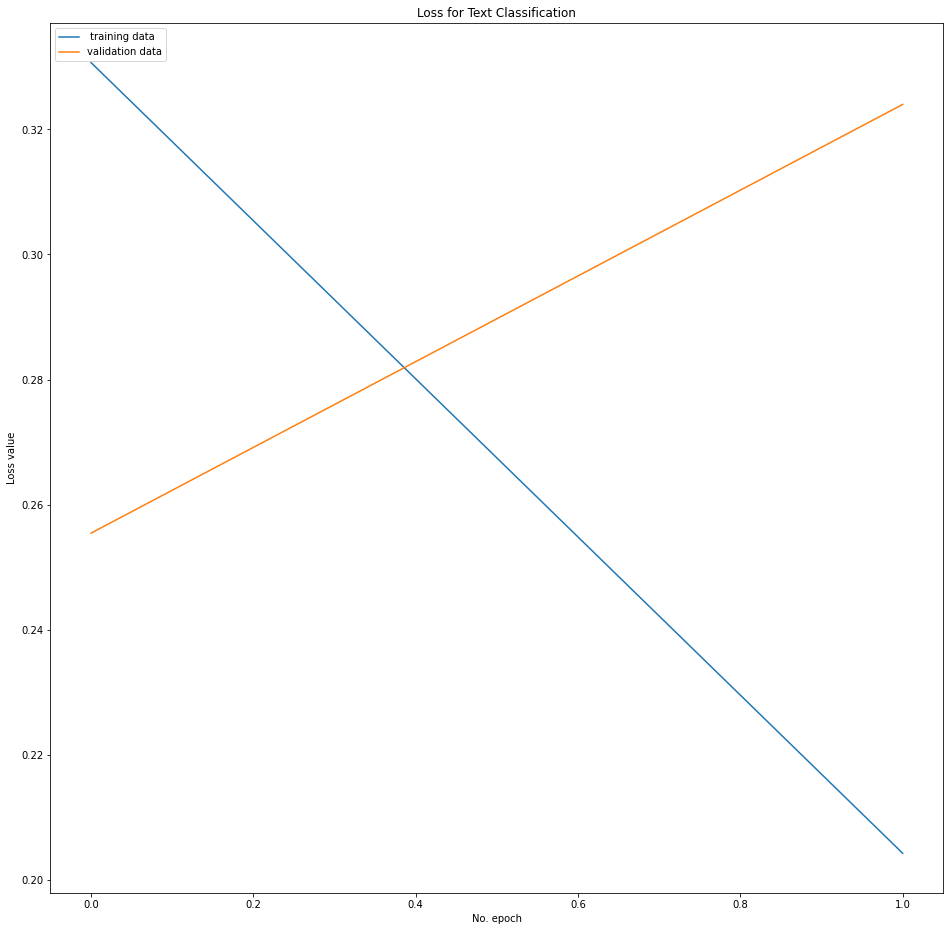

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

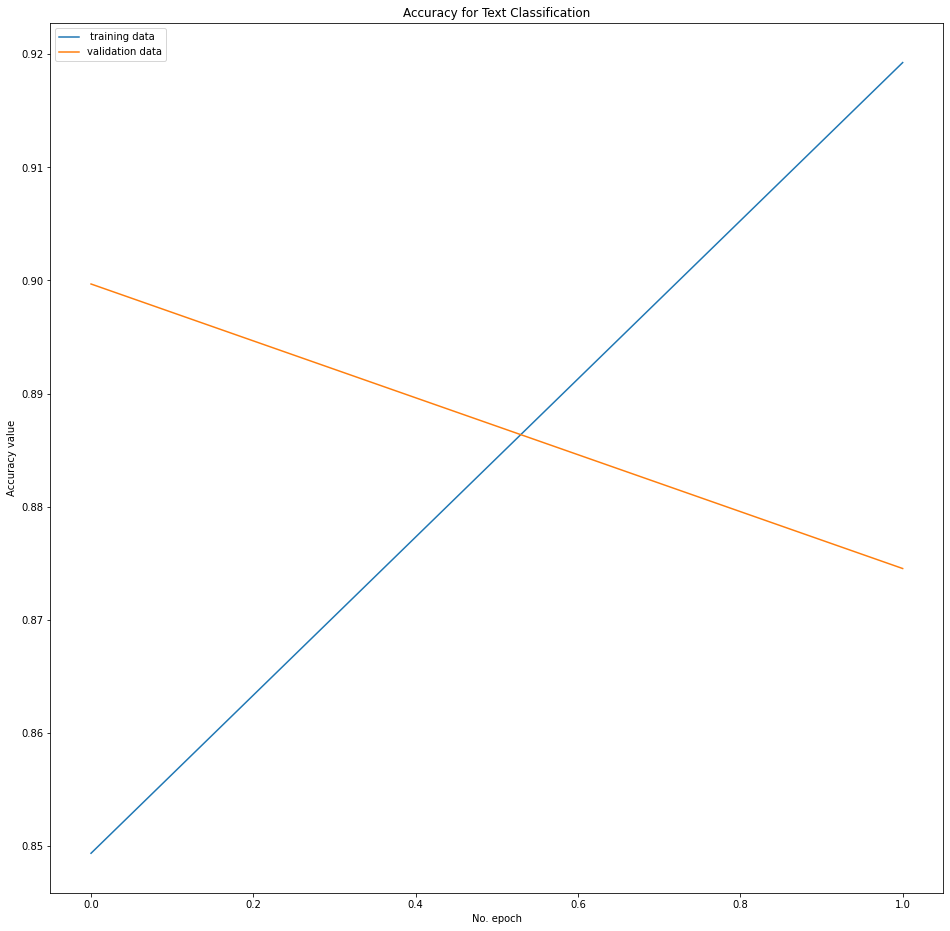

In [ ]:
plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
print(Y_test[:15])

0     1
1     1
2     0
3     1
4     1
5     0
6     0
7     0
8     1
9     0
10    1
11    0
12    0
13    1
14    0
Name: Sentiment, dtype: int32


In [ ]:
rnn_model.predict(X_test[:15])

array([[0.99648106],
       [0.99743223],
       [0.06446239],
       [0.8824909 ],
       [0.9972668 ],
       [0.03098997],
       [0.01172623],
       [0.07493022],
       [0.9910535 ],
       [0.14165345],
       [0.99870837],
       [0.07157999],
       [0.32420224],
       [0.99514055],
       [0.03043461]], dtype=float32)

In [ ]:
cnn_model.predict(X_test[:15])

array([[0.98774564],
       [0.9999945 ],
       [0.0617595 ],
       [0.7357297 ],
       [0.9964231 ],
       [0.01246372],
       [0.00173247],
       [0.07694256],
       [0.98384386],
       [0.5504651 ],
       [0.9939747 ],
       [0.8789278 ],
       [0.7110886 ],
       [0.99997824],
       [0.17521375]], dtype=float32)

In [ ]:
print("Generate rnn predictions")
predictions_rnn = rnn_model.predict(X_test)

Generate rnn predictions


In [ ]:
print("Generate cnn predictions")
predictions_cnn = cnn_model.predict(X_test)

Generate cnn predictions


In [ ]:
data_rnn = {'y_Actual':    predictions_rnn,
        'y_Predicted': Y_test
        }

In [ ]:
data_cnn = {'y_Actual':    predictions_cnn,
        'y_Predicted': Y_test
        }

In [ ]:
rnn_df = pd.DataFrame(data_rnn, columns=['Real','Predicted'])

In [ ]:
cnn_df = pd.DataFrame(data_cnn , columns=['Real','Predicted'])

In [ ]:
rnn_df['Predicted'] = np.where((rnn_df.Predicted >= 0.5),1,rnn_df.Predicted)
rnn_df['Predicted'] = np.where((rnn_df.Predicted < 0.5),0,rnn_df.Predicted)

In [ ]:
cnn_df['Predicted'] = np.where((cnn_df.Predicted >= 0.5),1,cnn_df.Predicted)
cnn_df['Predicted'] = np.where((cnn_df.Predicted < 0.5),0,cnn_df.Predicted)

In [ ]:
predictions_rnn = [1 if x >= 0.5 else 0 for x in predictions_rnn]

In [ ]:
print(predictions_rnn[:15])

[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]


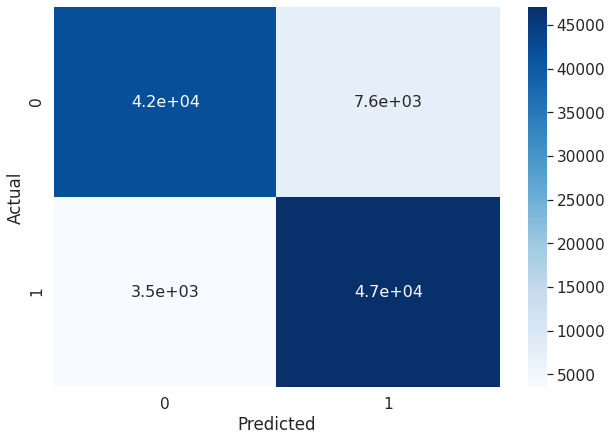

In [ ]:


from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


data = confusion_matrix(Y_test, predictions_rnn)
df_cm = pd.DataFrame(data, columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size



In [ ]:
predictions_cnn = [1 if x >= 0.5 else 0 for x in predictions_cnn]

In [ ]:
print(predictions_cnn[:15])

[1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]


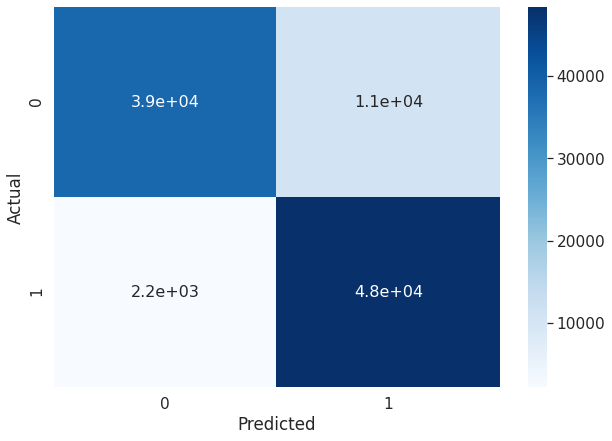

In [ ]:
data = confusion_matrix(Y_test, predictions_cnn)
df_cm = pd.DataFrame(data, columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size